# ADAvengers: Pints & Politics - Sipping Through Red, Blue, and Brew in U.S.  

In the light of recent elections and the present passion for beer in American culture, we embark on a unique journey to uncover link between politics and pints. Our analysis delves into the heart of the American lifestyle, exploring whether the beers we sip reveal more than just our taste preferences, perhaps even our political leanings!  

We will explore [BeerAdvocate](https://www.beeradvocate.com/) dataset which provides information about beers, breweries, users and their ratings. Dataset contains over 2 million reviews coming from U.S. users We find that this information is sufficient to conduct our analysis, leading us to focusing solely on the BeerAdvocate dataset. The reviews in the dataset span over years from 2001 to 2017. For our analysis particularly, data coming from `users.csv` (which provides information on location of user) and `reviews.txt`.  

We gathered political information from several different sources. For our analysis we required information about the winning parties in each U.S. state, in the election years 2004-2016, obtained from [U.S. President 1976-2020](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/42MVDX). To get more fine-grained data on age-specific voting preferences we used exit polls found on various different sources. The information was available for the mentioned election years, however not for all the states. This is due to the fact that exit polls are of interest in states that change their political climate over the years, swing states. Since conducting these surveys is costly, the consistently Democrat or Republican states are usually omitted.

**Note:** This Notebook contains frequent usage of interactive plots. This is due to the fact that problem we are discusing has mutiple dimensions - states, years, beer styles, ratings, sentiment, so it is more comprehensible for analyzing and reviewing when one can select/filter out displayed content. 

In [3]:
import pathlib
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np

data_dir_path = pathlib.Path("../../data")

from models.lda_topics_analysis_model import LDAAnalysis
from src.plots import plotting_utils
from src.plots.plotting_word_cloud import plot_word_cloud
import src.data.correlations as corr
from src.data import reviews_processing, load_and_find_party_winners
from src.plots import plot_state_map
from src.data import favourite_beers_processing
from plots.plotting_beer_characteristics import plot_beer_characteristics

In [2]:
%load_ext autoreload
%autoreload 2

## Pipeline for the analysis  

- Understanding the beer reviews and initial analysis
- Dive into political data
- Clustering of voting trends and look-alike analysis
- Comparison of beer trends between look-alike states
- Is swing pattern in states somehow noticable in beer preferences?
- Conclusion and Limitations

## What's behind beer reviews?  

As we stated, we mainly focused on `reviews.txt` file to extract all the necessary information for our analysis. This file first needed exhaustive parsing to be converted into .csv. Code for producing it can be found in `/src/data/load_and_parse_beeradvocate_reviews.py`. For further analysis we used parsed `reviews_df.csv`.  

Some preprocessing steps were needed for our dataset on presidental elections too. It initially containing number of votes each party candidate won in the specific years for a specific state. We converted those numbers into percentages and identified winning party as the one which won maximum percentage in each year for each state. This file is on our project's GitHub under `/data/generated/party_winners_over_years.csv` and is generated by script `/src/data/load_and_find_party_winners.py`.

In the following cell, we further process the `reviews_df.csv`. Namely in the *first step*, we merged it with `users.csv` to extract the information about the location of the user, i.e. where are they coming from, focusing solely on users coming from United States. After this first step of filtering we are left out with over 2 million reviews.
The sentiment analysis pipeline (see `src/models/sentiment_analysis_model.py`) produces extra columns (sentiment class & prediction score), we save this augmented dataframe as 2nd DataFrame in `reviews2_df.pkl`.

*First step* is to analyse the textual reviews that we have. We will make a first cloud of words to understand in general what words are mostly used

*Second step* is to aggregate beer styles in more general categories. By looking into the data we notice that there is 104 unique beer styles among reviewed beers which is a lot to analyze. Therefore, we hopped on a quick internet search to understand what are the most popular and common beer categories. Through this we identified: IPAs, Ales, Stouts, Porters, Lagers, Pilsners. Since Ales category contained many different subcategories with different properties (and also a lot of different reviews in our dataset), we opted to split it in Pale Ales, Red/Amber Ales and Other Ales - leaving us with total of 8 high-level beer categories. By keyword matching, we managed to assign beer styles into our 8 categories. Out of initial 104 unique beer styles, we were left with 56, accounting for 75% of total beer reviews.

*Third step*  Is to explain what exactly those 8 beer styles are. What beer characteristics do they have? (We therefore define by hand 5 beer characteristics of interest for visualisation). To do that we first study the topics in the whole beer reviews with LDA. And (spoiler) since those topics mostly talk about beer characteristics we can go further an embed those beer reviews and use a transformer model to embed in a vector space. This vector space can be used to measure the similarity of the reviews of a beer style (average vector) against each embedding vector of 5 beer characteristics that were defined.

*Finally*, we need to choose a meta-level aggreagation metric on which we will analyze preference between categorized beer styles (referred as simply beer styles in the later text and plots). For this purpose, we chose **average rating** calculated as mean of 5 aspects that beer reviewers' rate on BeerAdvocate website - palate, aroma, taste, appearance and overall. We opted for this one as we believed that it captures the best overall impression of the reviewer with the specific beer. Therefore, for every state, year, beer style combination we calculated mean of average ratings, ending with a single proxy for beer preference. Last step we took is to keep only reviews left in year span from 2004 to 2016 as those are years on which we have election data using the column `data` (which represents the moment when the review was left on the website). Everything is saved in table `results`.

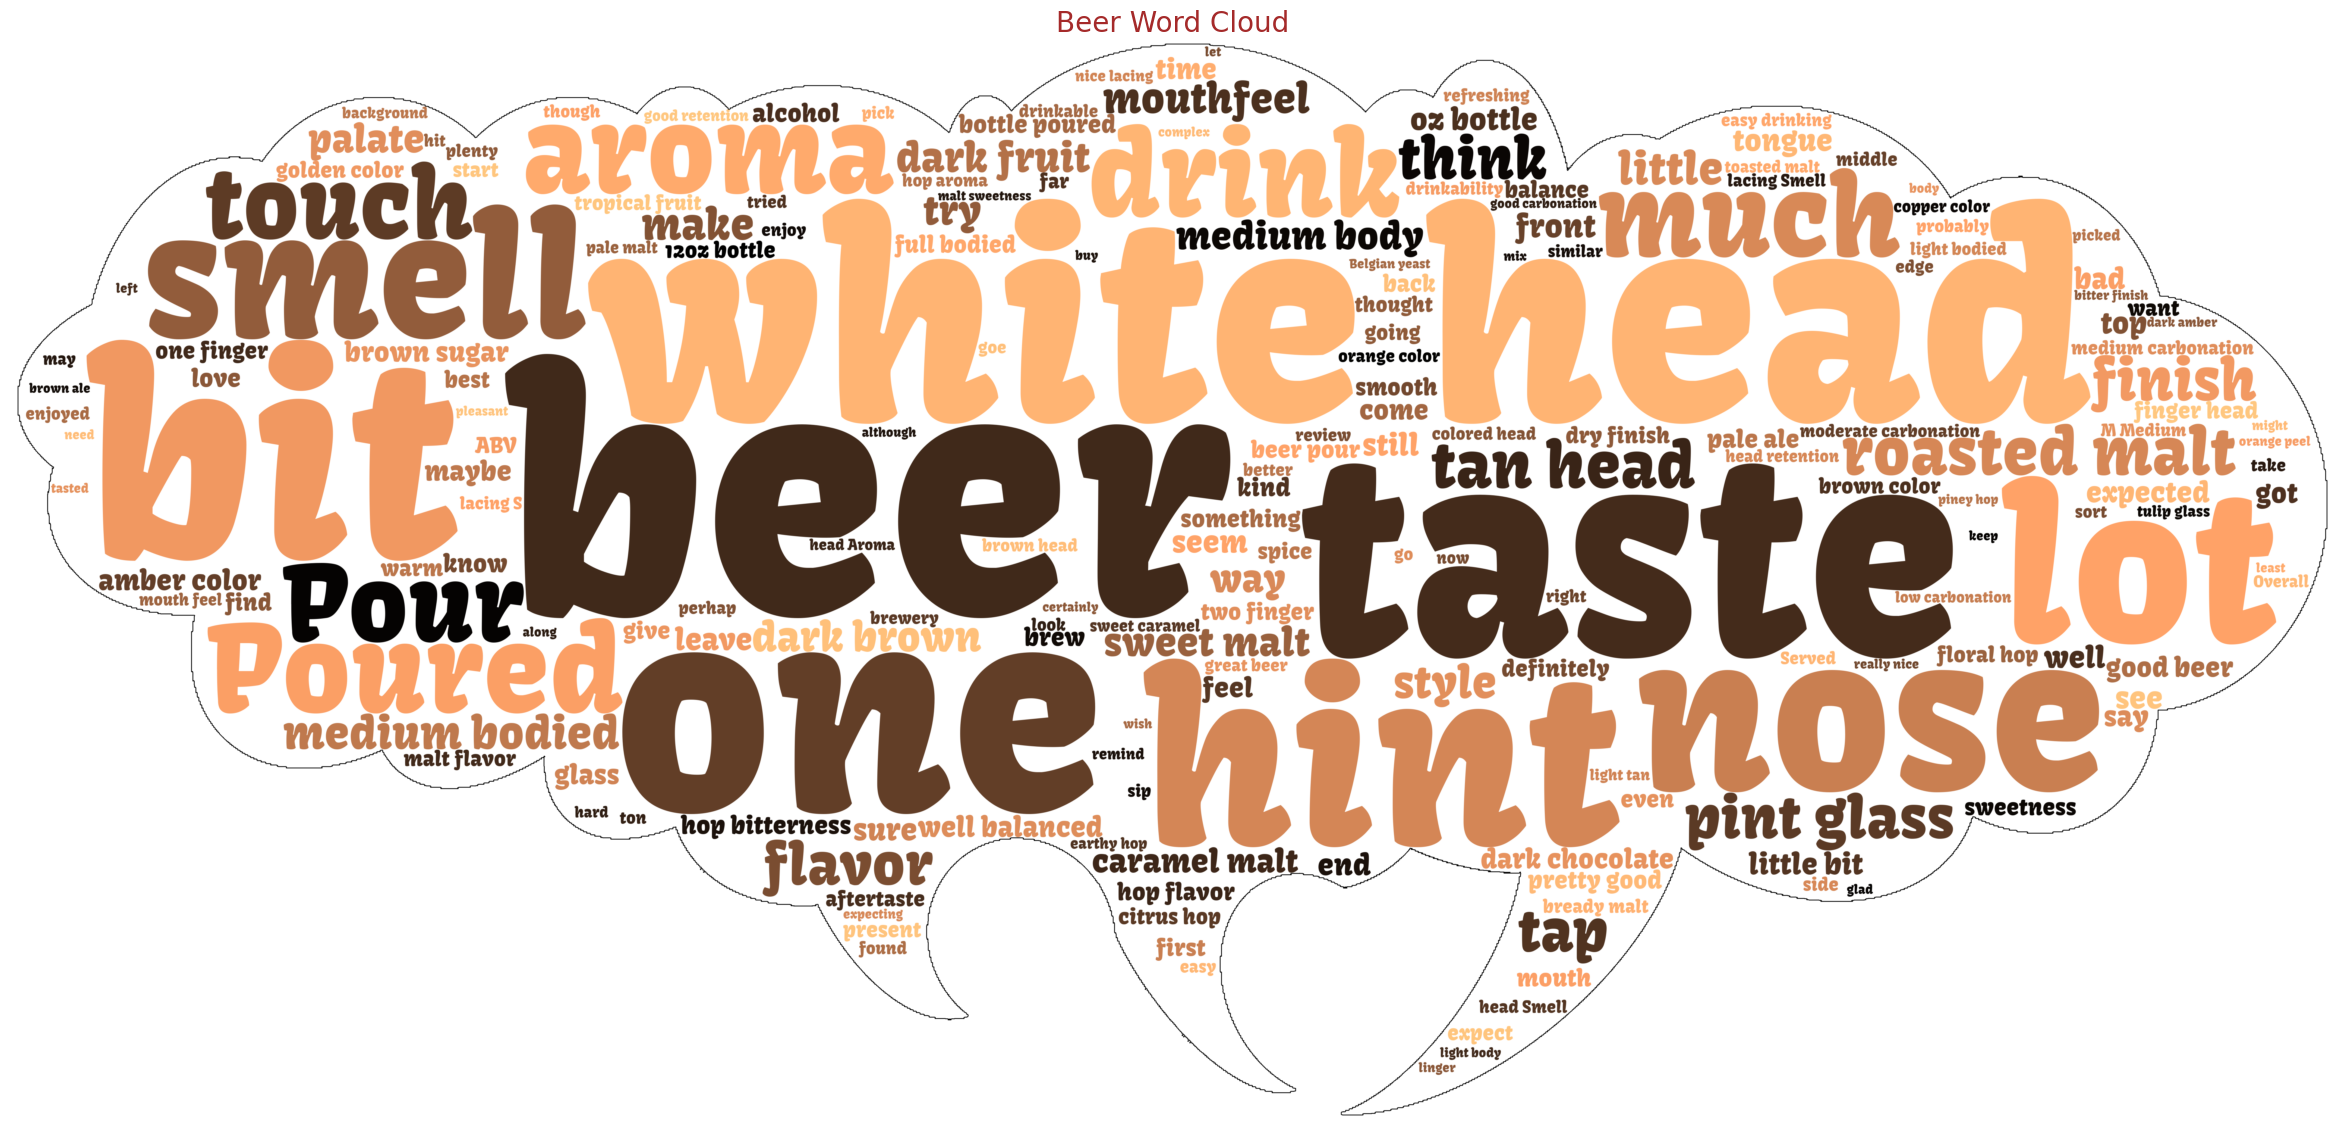

In [ ]:
# Let's visualize the cloud of words in the text reviews
plot_word_cloud()

In [ ]:
# Now we are performing an LDA analysis to extract the topics that we have in the reviews, the word cloud is promising a lot of time people mention the word taste, smell, aroma,... which is related to the beer characteristics and not to other things :)

reviews_df_path = data_dir_path / "generated" / "reviews_df.csv"
model_path = data_dir_path / "generated" / "biglda"

# load the already trained LDA model (see src/model/lda_topics_analysis_model.py)
model = LDAAnalysis()
model.load_dataset(reviews_df_path)
model.preprocess()
model.load_saved_model(model_path)
model.print_topics(num_words=10)

Loaded dataset with 2589586 reviews.
starting preprocess
preprocessing completed
[(0,
  '0.021*"hop" + 0.018*"light" + 0.018*"head" + 0.017*"nice" + 0.015*"malt" + '
  '0.014*"white" + 0.012*"good" + 0.011*"taste" + 0.011*"sweet" + '
  '0.011*"aroma"'),
 (1,
  '0.031*"dark" + 0.020*"brown" + 0.014*"head" + 0.013*"sweet" + 0.012*"malt" '
  '+ 0.011*"nice" + 0.011*"flavor" + 0.009*"chocolate" + 0.009*"roasted" + '
  '0.009*"bit"'),
 (2,
  '0.420*"-" + 0.040*"appearance" + 0.018*"\x96" + 0.012*"cork" + 0.010*"–" + '
  '0.008*"medium" + 0.007*"fantome" + 0.006*"lacing.s" + 0.006*"=" + '
  '0.004*"shared"'),
 (3,
  '0.017*"belgian" + 0.014*"sour" + 0.010*"fruit" + 0.010*"yeast" + '
  '0.009*"note" + 0.009*"tart" + 0.008*"flavor" + 0.007*"apple" + 0.007*"dry" '
  '+ 0.006*"quite"'),
 (4,
  '0.078*"bottle" + 0.042*"poured" + 0.019*"pint" + 0.018*"served" + '
  '0.013*"glass." + 0.012*"glass" + 0.011*"&amp;" + 0.010*"oz" + 0.009*"12" + '
  '0.008*"tap"'),
 (5,
  '0.032*"beer" + 0.019*"like" + 

We can summarize each topic as follows :\
Topic 0: Light, balanced beers and their aroma/taste notes.\
Topic 1: Dark, malt-forward beers (stouts, porters) and their roasted flavors.\
Topic 2: Appearance details, perhaps Belgian farmhouse bottles and shared tasting experiences (with some noise from formatting).\
Topic 3: Belgian/sour ales with tart, fruity yeast characteristics.\
Topic 4: Serving methods, packaging, and glassware descriptions.\
Topic 5: General beer impressions, overall taste/smell evaluations, and broad opinions.\
In essence, the LDA model seems to have identified a few style-related clusters (light vs. dark vs. Belgian/sour), one related to serving method/appearance, and a generic catch-all category.

As we can see the interpretation is that people mostly talk about the beer characteristics which is good news! We will be able to use the beer reviews as a proxy to understand the beer styles. But first let's find a way to regroup the 104 beer styles into just 8 large ones :

In [2]:
users_path = data_dir_path / "BeerAdvocate" / "users.csv"
reviews_path = data_dir_path / "generated" / "reviews_df.csv"
sentiment_path = data_dir_path / "generated" / "reviews2_df.pkl"
winners_path = data_dir_path / "generated" / "party_winners_over_years.csv"

users_reviews = reviews_processing.Reviews(users_path, sentiment_path)

year_list = list(np.arange(2004, 2017, 1, dtype=int))
results = users_reviews.aggregate_preferences_year(year_list, all_states=True)
winners = load_and_find_party_winners.state_winner_years(winners_path)

# Reviews for counts
total_reviews = users_reviews.filter_beer_type()

The plot displays word of cloud view of unique beer styles (56) we are left with after keyword-matching categorization (to 8 general categories) performed on 104 beer styles encompassed by reviews.

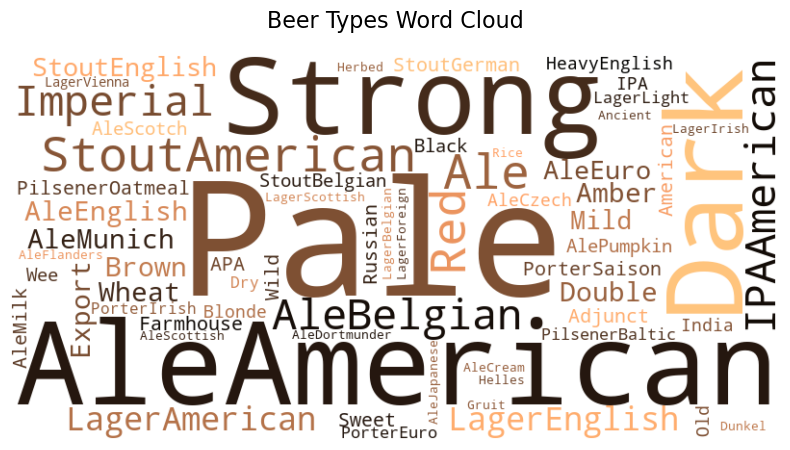

In [4]:
plotting_utils.create_worldcloud(total_reviews)

Now that we have the general 8 beer styles. We can try to use data to tell us what beer characteristic are present or not (value in range 0-1) in each beer style. To do this we embed the reviews of the beer reviews and regroup by averaging the vectors part of a beer style and see how close it is to each one of the 5 beer characteristic. We then visualize in a nice radar plot:

In [ ]:
plot_beer_characteristics()

The results are highly dependant of the model that we used and are meaningless for Stout style. But we can still notice some interesting insights:

Porter: it stands out with the highest values for Hop Intensity, Malt Profile, and Carbonation.
This reflects its bold flavors and carbonation, aligning with expectations for robust, malt-forward beers.

Pilsner: it has the highest Body/Texture and Carbonation, consistent with its crisp, refreshing nature.
Its Hop Intensity is lower, aligning with its balanced, smooth profile.

Stout: scores very low across all characteristics, the model is quite small and didn't grasp its characteristics.

IPA: it shows very high Alcohol Strength, which makes sense it is typically higher ABV of IPAs. Lower Hop Intensity than expected.


If we take a look at the range of values:

Some styles (for example Porter, Pilsner) display distinct profiles with strong highs and lows, making them easier to differentiate.

Other styles (such sas Pale Ale, Red/Amber Ale) seem more balanced and less distinctive. This reflects their versatile flavor characeristics.

We see that data can actually give us very interesting insights. Now that we have a real sense and know more about beer culture let's continue and study more about those 0 general beer styles.

After these preprocessing steps, we focus on understanding beer preferences among the U.S. reviewers, first by analyzing the number of reviews they left per beer style over the years. What we can notice from the plot is that number of reviews per beer style clearly increases over the years, which is expected due to the growing popularity of internet communities and rating websites in the late 2000s and early 2010s.  

Additionally, if we take a closer look at specific beer styles three types stand out as the most popular for reviewing, particularly **Other Ales**, **IPAs** and **Stouts**. As we already mentioned, Ales have many different subcategories, so it is not suprsining that they are frequently reviewed. Interestingly, Stouts are consistently ranked **third** after 2008, reflecting its stable popularity in the top 3 among beer-reviewing enthusiasts. Another key point is a substantial rise in IPA's reviewers, particularly in the mid-2010s. As we found on the [blog](https://www.beervanablog.com/beervana/2019/12/16/the-2010s-in-review) this period aligns with the time when *IPAs finally became the best-selling style in the craft segment*.

In [5]:
fig = plotting_utils.plot_review_count(total_reviews, year_list)

Continuing on these findings, where IPAs, Other Ales and Stouts emerged as the most-reviewed beer styles, we now shift our focus to understanding which beer styles receive the highest ratings across the United States. For this purpose we use interactive plot of U.S. map where beer styles are groupped by colors and the slider gives an option so see evolutions of these trends over the age range 2004 to 2016.

In [6]:
# Reformat data for plotting
favourite_beers = favourite_beers_processing.FavouriteBeers(results)
data = favourite_beers.favbeer_process_for_mapplotting()
data_plot = plot_state_map.transform_state_abbreviations(data)
data_plot = data_plot.reset_index()

winners_drop = winners[winners.index != 'District Of Columbia']
winners_plot = plot_state_map.transform_state_abbreviations(winners_drop)
winners_plot.sort_values(by='year', ascending=True, inplace=True)
winners_plot = winners_plot.reset_index()

# Initialize the PlotStateMap object with already abbreviated state names
hover_data = {"beer_style": True, "ratings": True, "years": False}
state_map = plot_state_map.PlotStateMap(data_by_state=data_plot, hover_data=hover_data, animation_frame='years', title="Favourite Beer Styles Across U.S. States", state_names_already_abbreviated=True, dataMetric="beer_style")

# Plot the map
fig = state_map.plot_map()

dataframe


**Stouts**, **Porters** and **IPAs** claim the title of nation's favourites. Moreover, after 2010, Stouts dominate as the top-ranked beer style in the majority of states. To further signal a clear preference among reviewers, Stouts claim the top spot in 47 out of 50 states in 2016. Meanwhile, IPAs, though experiencing a surge in popularity in reviewers’ comments during the mid-2010s, don't have a complementary effect on ratings. Interestingly, among the selected beer styles, Lagers appear to be overlooked, never claiming the top spot as a favourite in any state.  

Another interesting point we observed is that some states frequently chose one beer type over the other. To quantify this we analyzed the frequency of selection of beer style as a favourite for each state from 2004 to 2016. Upcoming plot displays chart with dropdown button that allows selection of specific state.  

It can be noticed that some states, such as Kentucky, Massachusetts, Connecticut, Ohio and Oregon show remarkable consistency in their tastes, choosing Stouts as a favourite every single year. On the other hand, states such as Montana, North and South Dakota, Alaska, Utah, Vermont and Wyoming exhibit more diverse tastes, switching between different beer styles as favourites over the years. 

In [7]:
plot = plot_state_map.barplot_fav_styles_per_state(results, data)

Beside numerical ratings, users also left textual reviews. To add another dimension to our analysis, we decided to use [DistilBERT base uncased finetuned SST-2](https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english) model to assess sentiment of the textual reviews, i.e. whether it is POSITIVE or NEGATIVE. This approach resulted in another table `reviews2_df.pkl` which contains additional two columns: `sentiment_label` and `sentiment_score` which represent category to which review is classified (either POSITIVE or NEGATIVE) and how confident the model is to its prediction.  

Again, we need to perform some kind of meta-level aggregation on this preference metric. We opted to do the following: for each state, year, beer style combination we counted number of reviews identified to have positive or negative sentiment and then calculated their fraction in total number. To assess this type of beer preference metric we display the upcoming plot.

The plot shows trends in change of fraction of both positive and negative sentiment counts for some subset of states (we will speak more about this subset later, but these are essentially states on which we found election poll results for every election year in time frame 2004-2016).  

The previously observed trend of Lagers not being favoured is reflected here as well, with the fraction of positive reviews for them being substantially lower compared to other beer styles across all states. High fraction of positive reviews (around 80%) for most of the years, beer styles and states reflects general affinity of reviewers to leave positive comments and also high ratings.

Potentially, with more broader emotional sentiment analysis we could've captured somewhat different results, however that would've increased the dimensionality of our already high-dimensional problem and make analysis more complex so we stayed with this choice. Thus, since the positive sentiment fraction is rather large for all beer styles, although we will include it into our analysis, it won’t be in the focus.

In [11]:
# Loading and filtering sentiments
sentiment_path = data_dir_path / "generated" / "reviews2_df.pkl"

sentiment_reviews = reviews_processing.Reviews(users_path, sentiment_path)
per_sentiment = sentiment_reviews.posneg_sentiment_aggregation_counts(all_states=False)
per_sentiment_filt = per_sentiment[per_sentiment['year'].isin(year_list)]

fig_years = plotting_utils.plot_sentiment_posneg_states(per_sentiment_filt)

## Dive into Politics 

Now that we have identified the most popular beer styles across U.S. states, we can explore whether we can link the taste buds of these beer drinkers to their political affiliation. Specifically, we will examine the U.S. states during four key election years: 2004, 2008, 2012, and 2016 - which already led to our analysis being narrowed down to time range from 2004 to 2016. To begin, we will determine which political party won each state in these elections. To do so we provie a plot showing Election Winners across U.S. states, where Red represent Republican and Blue Democrat states.  

As we can see some states remained consistent in their political leanings over the years, with the same party winning across all four elections. For example, California, New York, and Massachusetts are consistently Democrat, while Texas, Arizona, and Montana have consistently leaned Republican. On the other hand, states that shift their political affiliations between elections, i.e. **swing states**, are particularly interesting to analyze, as they often play a decisive role in determining the outcome of the elections. Some examples are Pennsylvania, Nevada, Virginia and Indiana. In the rest of the analysis we will mention other too. 

In [12]:
# Plot winning parties
hover_data = {"winner": True, "state": True, "year": False}

state_map = plot_state_map.PlotStateMap(data_by_state=winners_plot, hover_data=hover_data, animation_frame='year', title="Election Winners Across U.S. States", state_names_already_abbreviated=True, dataMetric="winner")

# Plot the map
fig1 = state_map.plot_map()

dataframe


## Clustering of Voting Trends with Look-alike Analysis  

Now, let's dive into the most interesting part of our analysis - understanding whether political leaning influences beer preferences!

In our analysis, it is important to consider **confounding factors** that could influence both political affiliation and the beer preference.  

Key factors to consider include:
* age, 
* wealth (i.e., economic status), 
* education level, 
* ethnicity, and others.  

However, these factors are *tricky* to determine for each specific user.  
 
Extracting details like educational background from their beer review text is challenging and one would argue that even the greatest writers in history might not produce the most eloquent or inspiring beer reviews. We even tried approaching the problem of unknown age with a proxy - assuming that each user was at least 21 years old when leaving the review and calculating the age as `21 + years(date_user_joining - date_review_left)`. However, this left us with extremely skewed distribution with users 'being able to age' only between 21 and 37 (if they were loyal reviewers from 2001 to 2017).  

Additionally, only information about political leanings that we had was on the level of state.

Therefore, we decided to conduct our analysis at the **state level**. What this means is that we will aggregate beer preferences (average rating and fraction of positive sentiment) on the state level (which we already explained how it was achieved in the first section) and use it as a proxy for a state-level beer preference.  

In our state-level analysis, we will focus on two main cofounding factors: *age* and *geographical location*. As explained, extracting age information wasn't feasible, therefore we opted to outsource this demographic data. We make an *assumption* that the beer drinkers and reviewers on the website have a uniformly distributed age in range between 18 and 64. Other potential factors, such as ethnicity or income per capita, were excluded to avoid additional complexity and the difficulty of analysing their mutual impact on each other.

The age data linked to voting patterns was obtained from **exit polls** for the election years: [2004](https://www.nytimes.com/elections/2012/results/president/exit-polls.html), [2008](https://archive.nytimes.com/www.nytimes.com/elections/2008/results/president/national-exit-polls.html?mod=article_inline), [2012](https://www.nytimes.com/elections/2012/results/president/exit-polls.html), and [2016](https://edition.cnn.com/election/2016/results/exit-polls) with age groups categorized as 18-29, 30-44, and 45-64. This data provides the percentage of Democrat and Republican votes for each age group across 17 states, since exit poll data was not available for all states due to poll not being conducted, as previously mentioned. States we are left with are: Arizona, California, Florida, Georgia, Indiana, Iowa, Kentucky, Nevada, New York, New Hampshire, North Carolina, Pennsylvania, South Carolina, Texas, Virginia, Wisconsin.

Since we have more fine-grained information about beer reviews, and therefore beer preferences for each state, which can be grouped at the year level or even the 6-month level, we decided to **interpolate** the voting data to cover *each year*. To achieve this, we applied linear interpolation for the years between election ones. The results are illustrated in the following plot which displays Vote Distribution for Democrats and Republicans by State, Age Group and Year.

In [17]:
# Interpolate voting data
age_groups = ["18_29", "30_44", "45_64"]
voting_data_merged = corr.merge_voting_by_years(data_dir_path)
interpolate_data = corr.interpolate_votes(voting_data_merged)

interpolated_data_reshaped = corr.reshape_data(interpolate_data, year_list, age_groups)
plot_state_map.plot_vote_distribution(interpolated_data_reshaped, age_groups)

Some interesting observations:
* In New York, young voters (aged 18-29) consistently favour Democrats over Republicans. 
* On top of that young voters are usually the ones voting the most for Democrat party even in more Republican-leaning states. However, those percentages are smaller compared to Democrat states. For example, the percentage of young Democrat voters in New York (a Democrat state) is consistently higher than in Texas (a Republican state). 
* Interestingly, for the oldest age group in Arizona (a Republican state), the ratio of Democrat to Republican voters remains relatively stable over the years, whereas the other two age groups show more dynamic changes.

Given the scale of the data, spanning 13 years and 17 states, it is challenging to draw conclusions about political trends, changes over time and similarities between states.  

To address this and perform look-alike type of the analysis, we opt for an unsupervised approach to group states and identify patterns in the data. Specifically, we apply **K-Means clustering** to this time-series data - percentage of democrat votes for each age group, in the span of 13 years. The number of clusters is set to **3**, based on the assumption that they represent *consistently Democrat states*, *consistently Republican states*, and *swing states*.  

The clustering was performed using 3 distinct clustering methods, considering we were dealing with time series voting data: 
- K-Shape
- K-Means
- Time Series K-Means using Dynamic Time Warping metric

For more details and results, refer to `src/ipynb scripts/clustering_voting_data.ipynb`. The final choice was made to use the K-Means method, since it was the only one providing 3 distinct clusters, as requested.

The resulting clusters are shown below. PCA decomposition is used to represent high-dimensional time series in 2 dimensions.


In [19]:
# Drop all columns containing 'republican' in their names since they don't add more information 
interpolate_data_filt = interpolate_data.loc[:, ~interpolate_data.columns.str.contains('republican')]

# Apply K-Means 
kmeans = KMeans(n_clusters=3, random_state=42, n_init="auto").fit(interpolate_data_filt)
states = interpolate_data_filt.index
kmeans_labels = kmeans.labels_
state_clusters = dict(zip(states, kmeans_labels))

# Visualization of clustering on a lower dimension
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(interpolate_data_filt)

fig = plotting_utils.plot_clustering(reduced_data[:, 0], reduced_data[:, 1], kmeans_labels, states)

We observe some interesting results.  

On the far right, funnily enough, we see New York and California - two consistently Democratic states known for their progressive policies and strong liberal voting history. On the left, clustered together are Texas, Arizona, Georgia, Kentucky and South Carolina, which are Republican states, known for their strong conservative values. Indiana, a swing state (which had Republicans win on three ocasions in 2004, 2012 and 2016), is also part of this cluster. In the middle we observe a cluster of swing states, with an exception of New Hampshire, which is a Democrat state. 

 Therefore, we will consider that these clusters represent Democrat, Republican and swing state groups of states that have *similar voting trends*, i.e. **look-alike states**.

## Comparison of Beer Preferences Trends between Look-alike States

In our effort to determine whether political leanings influence beer tastes, we analyze *trends of beer preferences* - defined as:
* Time-Series of *average ratings* for specific beer style
* Time-Series of *fraction of reviews with positive sentiment* for specific beer style  

How we perform the comparison?  

We take representative pairs of states - either from the same or different clusters (this implies similar or different political voting trends between them) in previous section, taking into account also geographical proximity and try to see whether there is similarity in *trends of beer preferences* between them. We quantify the similarity of these trends between selected pair of states by computing both *Spearman and Pearson correlation coefficient* between trends.  

With this approach we perform **looka-alike type of analysis**.  

As we mentioned before this analysis is multi-dimensional and therefore a bit tricky to present comprehensibly. For this purpose we created dynamic and interactive Dash applications for both trends in average ratings and fraction of reviews with positive sentiment. Applications contain dropdown buttons, which allow users to specify pair of states, as well as beer style they want to analyze.  

After selection, plot shows up displaying specific beer preference trend over years, with markers on election years indicating which party won the race on those elections. Additionally, calculated Pearson and Spearman correlation coefficients are also displayed. 

In [27]:
# App for displaying beer style ratings by state
average_ratings = users_reviews.aggregate_preferences_year(year_list, all_states=False)
app1 = plotting_utils.BeerStyleTrendsDashApp(average_ratings, winners, plotting_utils.get_beer_styles_data, 'Ratings')
app1.run(port=8051)

In [23]:
# App for displaying Positive Sentiment Fraction per beer style per state
positive_sentiment = sentiment_reviews.sentiment_to_wide(sentiment_drop='NEGATIVE', sentiment_keep='POSITIVE', all_states=False, year_list=year_list)

app = plotting_utils.BeerStyleTrendsDashApp(positive_sentiment, winners, plotting_utils.get_beer_styles_data, 'Positive Sentiment Fraction')
app.run(port=8050)

Having 8 different beer styles to compare makes our analysis harder. To reduce complexity, we decided to choose 3 beer styles to take closer look at. Specifically, we opted for **IPAs** and **Stouts**, as these are the most popular and frequently reviewed beer styles. Additionally, we also picked **Lagers** as they are typically the least popular with the lowest average ratings and lagerst fraction of reviews with negative sentiment.

As we said, we focus on representative pairs of states, specifically:
* New York and California - two Democrat state representatives, though located on opposite sides of the country,
* Arizona and Texas - two Republican state representatives, close geographically,
* New York and Georgia - Democrat and Republican states, close geographically,
* New York and Arizona - Democrat and Republican states, distant geographically,
* Arizona and South Carolina - two Republican state representatives, distant geographically,
* Nevada and Florida - swing states, on opposite coasts,
* Pennsylvania and Virginia - swing states, close geographically.

Even though we created Dash applications to allow nice visualization of trends for Ratings and Fraction of Positive Sentiment, we weren't able to put them on the website in our data story (app required backend support).  

Therefore, we made a plot that selects pairs of these representative states to make comparison between their trends on the subset of beer styles we chose.  

The following cell produces the described plot. On the dropdown button user can select pair of predefined states which he wants to analyze. Three subplots are updated with the trends of average ratings and fraction of positive sentiment for specific beer style. Legend is interactive, so users can select specific trends they want to observe further.  

Additionally, title of each subplot is updated with the Spearman correlation coefficient quantifying the relationship between trends.  

Finally, markers on the plots indicate winning political party each election year. 

In [28]:
# Predefined states and beer styled 
predef_state1 = ['New York', 'Arizona', 'New York', 'New York', 'Arizona', 'Nevada', 'Pennsylvania']
predef_state2 = ['California', 'Texas', 'Georgia', 'Arizona', 'South Carolina', 'Florida', 'Virginia']

beer_styles = ['IPA', 'Stout', 'Lager']
election_years = [2004, 2008, 2012, 2016]

fig = plotting_utils.pairwise_trendplot(predef_state1, predef_state2, beer_styles, year_list, election_years, average_ratings, positive_sentiment, winners)

Findings:  

* **New York and California** - In terms of average ratings, we can see very similar and highly Pearson-correlated trends for IPAs (0.82) and Stouts (0.89). For Lager, ratings follow a similar pattern in both states until 2016, when the rating in California reaches a higher value then in New York. When it comes to trends in fraction of positive sentiment, we notice a moderate positive Spearman-correlation between two states for IPAs (0.65) and Stouts (0.55). Interestingly, while there is increase in average ratings for IPAs, accompanying reviews show declining fraction of positive.

Could this similarity in beer taste trends, considering the geographical distance of these states indicate the influence of their left-leaning political preference? Let's see some other examples.

* **Arizona and Texas** - We can observe that for IPAs and Stouts, the trends of average ratings have a Pearson correlation of 0.77 and 0.75, respectively, and the trends are rather similar, both having an increase after 2008. For Lager, we see that the trends have a slightly lower value of correlation, however, the curves reach the same value in 2016. In terms of sentiment, we do not see any significant Spearman correlation for IPAs (0.12) and Stouts (0.21), while for Lagers it's moderately positive (0.51). 

* **New York and Georgia** - Have very similar trends across all beer styles with Pearson correlation being between 0.5 and 0.76. *Them being on opposite political sides poses a question of whether its closeness influences the similarity in beer preference trends. For example, the correlation of IPAs and Stouts trends have a lower correlation value (around 0.55) for Georgia (Republican) and California (Democrat) than Georgia and New York.  

* **New York and Arizona** - Have a Pearson correlation value of around 0.7 for average rating trends between IPAs and Stouts, while for Lagers it is a higher value of 0.84. Them being far apart and on opposite sides of political sprectrum, we can conclude that neither politics nor geographical location have an influence on their beer trends being related. 

* **Arizona and South Carolina** - It is interesting to see that for these two Republican states, not close geographically, the value of Pearson correlation for average ratings for IPAs is -0.04 (the curves seem to be rather constant) and the Spearman correlation being of value -0.23 suggesting the trends are not being influenced by their same political affiliation. The results are also similar for Stouts for these two states, both correlations for average ratings being around 0.2. 

* **Nevada and Florida** - When observing their IPAs average rating curves, we can see they follow a similar trend until 2013, and they completely diverge in 2016, when Florida votes Republican and Nevada Democrat. Also, for Stouts, we see that the curves overlap in 2008, when Democrats take over, while, conversly there is a larger difference in 2016 when they do not share the winning party. 

* **Pennsylvania and Virginia** - For IPAs, the average rating curves are also closer in election years when the states vote for the same party, while diverging for 2016, however in opposite fashion then for Nevada and Florida, with Democrats giving higher average scores (over 4) then Republicans (around 3.5). For the rest of the beer styles, we cannot observe some specific patterns in trend change. 

For more detailed analysis of Pearson correlations between trends of average ratings, one can look into Heatmap of Pearson Correlation Coefficent between pairs of state and for specific beer style which can be chosen through dropdown menu.

In [29]:
fig1 = plotting_utils.plot_correlation_matrix(average_ratings, beer_styles, year_list)

These results lead us to delve deeper into trend analysis of swing state beer preferences. 

## Is 'Swing Pattern' in 'Swing States' somehow noticable in Beer Preferences? 

Finally, we want to assess how beer preferences change for states that have changed their political leaning over the years, often referred to as **swing states**. For this purpose, we decided to look at the trend of the top 3 favourite beer styles by average rating and compare it between swing states with the same **swing pattern**. We consider two states to have the same *swing pattern* if the same party won in the same years across both states. 

Through this approach, out of all available swing states that we had in out pool (of 17 states) we identified:
* Pennsylvania and Wisconsin - both voted Republican in 2016
* Ohio, Iowa and Florida - both voted Republican in 2004 and 2016 and Democrat in 2008 and 2012
* Indiana and North Carolina - both voted Democrat only in 2008
* Nevada and Virginia - both voted Republican only in 2004 

To easily identify their geographical proximity jointly with voting patterns we created the following plot. 

In [30]:
# Swing pattern 
fig1 = state_map.plot_swing_pattern()

In the following plot, we display trends of top 3 favourite beer styles by average ratings across years for the above mentioned pairs of swing states with similar swing pattern.

In [32]:
# Compare top3 favourite beer styles between two selected states
object_class = favourite_beers_processing.FavouriteBeers(results)
top_three = object_class.threefavbeer_for_barplotting()

state1 = ['Wisconsin', 'Ohio', 'Iowa', 'North Carolina', 'Nevada', 'Ohio']
state2 = ['Pennsylvania', 'Iowa', 'Florida', 'Indiana', 'Virginia', 'Virginia']
fig = plot_state_map.barplot_threefav_styles_compare(top_three, state1, state2)

Findings:

* For the first pair, **Pennsylvania and Wisconsin**, Democrats were ruling party during the whole period we are observing. Therefore, it is interesting to notice more or less consistent selection of top 3 favourite beer styles. 

* Second pair we are analyzing are **Ohio and Iowa**, states that besides having similar *swing pattern* are also geographically close in the Mideast. While Ohio has steady selection of top 3 favourites with minor favouring of Other Ales in 3rd place during Obama's first term, Iowa experiences a substantial shift in tastes after switching between Republican and Democrat ruling in 2008, with rise in popularity of Stouts.This suggests that local factors beyond political affiliation, can affect beer preferences. 

* Interestingly, **Florida** which has the same `swing pattern` but is not geographically close to **Iowa** experiences similar shift in tastes with overtake of top spot by Stouts after 2008, indicating that political factors might be driving force for it. Hypothetically, one could speculate that for reviewers of Florida and Iowa, IPAs are associated with more Republican-leaning. 

* This hypothesis is not reflected in **North Carolina** and **Indiana** which voted Democrat only in 2008, with single interesting observations being that reviewers from Indiana favoured Porters on the 3rd place during this time. States such as Ohio and Virginia, which are geographically close to North Carolina and Indiana in the East Coast region (some even neighboring) all have rather similar trends in this context, suggesting that geographical or other local factors might play a more significant role in shaping beer preferences than politics in these cases.

* Finally, we come to **Nevada** and **Virginia**, which both voted Republican only in 2004. These 2 display quite different trend in top 3 favourites, which might be due to being on opposite sides of the country. Interestingly in Nevada during Democrat times IPAs are not as favoured as in other states, being on 3rd position after 2011. 

## Conclusion and Limitations  

Although we observe potential patterns in beer preferences, particularly among countries with similar voting trends, including swing states that shift their political climate over the years, a more detailed analysis is necessary to draw any further conclusions. 
 
Firstly, having data available for all states is crucial to ensure a larger dataset for analysis and to reduce variance in the results.  

Additionally, a more in-depth causal analysis is needed to identify and separate other potential factors influencing beer preferences.  

Another limitation lies in how beer preferences are defined, specifically through beer styles. Stout reviews are overrepresented and dominate as the top-ranked beer style across the U.S., making it challenging to identify distinct preferences between different states. A more detailed analysis based on aspects, keywords associated with beer taste could provide greater insights.  

Lastly, we observe a general increase of trend in average ratings across all styles and states, contributing to the high Pearson correlation value. Could this increase be linked to the growing popularity of the internet over the years, making reviews more common in day-to-day life?  

Additionally, could the rise in high-value ratings be attributed to the halo effect (a cognitive bias where an overall positive impression influences specific judgments)? Exploring these possibilities could provide further clarity.  

Moreover, the basic positive/negative sentiment analysis does not provide sufficient distinction between beer styles, so incorporating a broader range of sentiment indicators would likely yield more meaningful results.  

All of these are steps that can be undertaken in future, to make this analysis more scientifically contributing.
